# Baysian Two-way Fixed Effects

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

island_ids  year  pseudo_year region_codes  prefecture_codes  \
0             67  1970         1970        32202                32   
1             67  1975         1975        32202                32   
2             67  1980         1980        32202                32   
3             67  1985         1985        32202                32   
4             67  1990         1990        32202                32   
...          ...   ...          ...          ...               ...   
1858         226  2000         2000        39424                39   
1859         226  2005         2005        39424                39   
1860         226  2010         2010        39424                39   
1861         226  2015         2015        39424                39   
1862         226  2020         2020        39424                39   

      population  treatment_group  treatment_group_mainland  bridge_year  \
0            NaN                1                         1         1999   
1            NaN                1                         1         1999   
2            NaN                1                         1         1999   
3            NaN                1                         1         1999   
4            NaN                1                         1         1999   
...          ...              ...                       ...          ...   
1858       398.0                1                         1         1957   
1859       365.0                1                         1         1957   
1860       343.0                1                         1         1957   
1861       284.0                1                         1         1957   
1862       225.0                1                         1         1957   

      pseudo_bridge_year  ...  connect_mainland_year  \
0                   1999  ...                   1999   
1                   1999  ...                   1999   
2                   1999  ...                   1999   
3                   1999  ...                   1999   
4                   1999  ...                   1999   
...                  ...  ...                    ...   
1858                1957  ...                   1957   
1859                1957  ...                   1957   
1860                1957  ...                   1957   
1861                1957  ...                   1957   
1862                1957  ...                   1957   

      after_treatment_mainland        income  area_km2  distance_m   log_pop  \
0                            0           NaN      0.28       615.0       NaN   
1                            0           NaN      0.28       615.0       NaN   
2                            0           NaN      0.28       615.0       NaN   
3                            0  4.243674e+07      0.28       615.0       NaN   
4                            0  4.786833e+07      0.28       615.0       NaN   
...                        ...           ...       ...         ...       ...   
1858                         1  5.113370e+02      0.56       110.0  5.986452   
1859                         1  4.533435e+02      0.56       110.0  5.899897   
1860                         1  3.903833e+02      0.56       110.0  5.837730   
1861                         1  4.064721e+02      0.56       110.0  5.648974   
1862                         1  3.758701e+02      0.56       110.0  5.416100   

        pop_star  log_pop_star  time_since_treatment  is_already_treated  
0            NaN           NaN                   -29                   0  
1            NaN           NaN                   -24                   0  
2            NaN           NaN                   -19                   0  
3            NaN           NaN                   -14                   0  
4            NaN           NaN                    -9                   0  
...          ...           ...                   ...                 ...  
1858  -51.742797     -0.002503                    43                   1  
1859   88.193373  

## TWFE

$$
\begin{aligned}
\log{Y_{it}} &\sim \mathcal{t}(\nu=3, \mu_{it}, \sigma^2) \\
\mu_{it} &= \text{intercept} + \beta \cdot T_{it} + \text{islands}_i + \text{year}_{t} \\
\sigma &\sim \text{Half-}\mathcal{t}(\nu=3, 1) \\
\text{intercept} &\sim \mathcal{N}(0, 1) \\
\beta &\sim \mathcal{N}(0, 1) \\
\text{island}_i &\sim \mathcal{N}(0, 1) \\
\text{year}_t &\sim \mathcal{N}(0, 1) \\
\end{aligned}
$$

## 正規分布

### ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


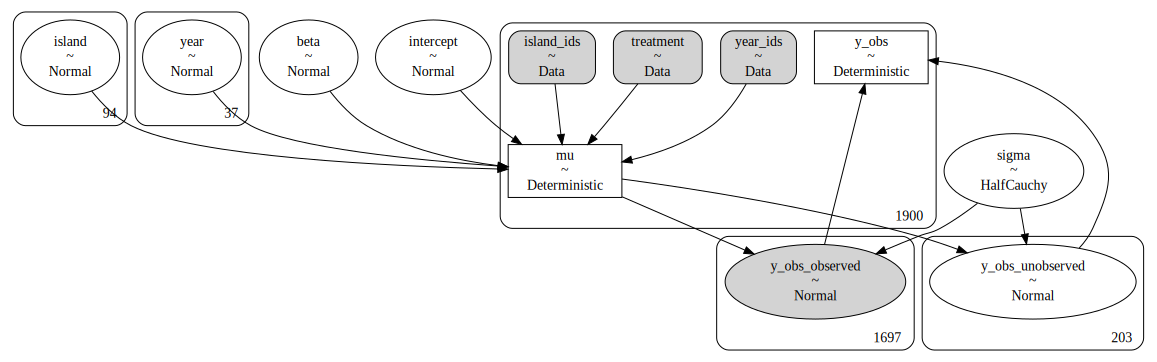

In [ ]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as twfe:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'])
    year_ids = pm.Data('year_ids', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])

    # priors
    # random effects
    island = pm.Normal('island', mu=0, sigma=1, shape=len(unique_island_ids))
    year = pm.Normal('year', mu=0, sigma=1, shape=len(unique_years))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfCauchy('sigma', beta=1)

    # expectation
    mu = pm.Deterministic('mu', intercept + beta * treatment + island[island_ids] + year[year_ids])

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(twfe)

In [10]:
with twfe:
    trace_twfe = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [11]:
az.summary(trace_twfe, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.527  0.200     5.152      5.940       0.01    0.007     425.0   
beta       0.305  0.028     0.254      0.360       0.00    0.000    6486.0   
sigma      0.229  0.004     0.221      0.238       0.00    0.000    4826.0   

           ess_tail  r_hat  
intercept     765.0   1.01  
beta         3316.0   1.00  
sigma        2797.0   1.00

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


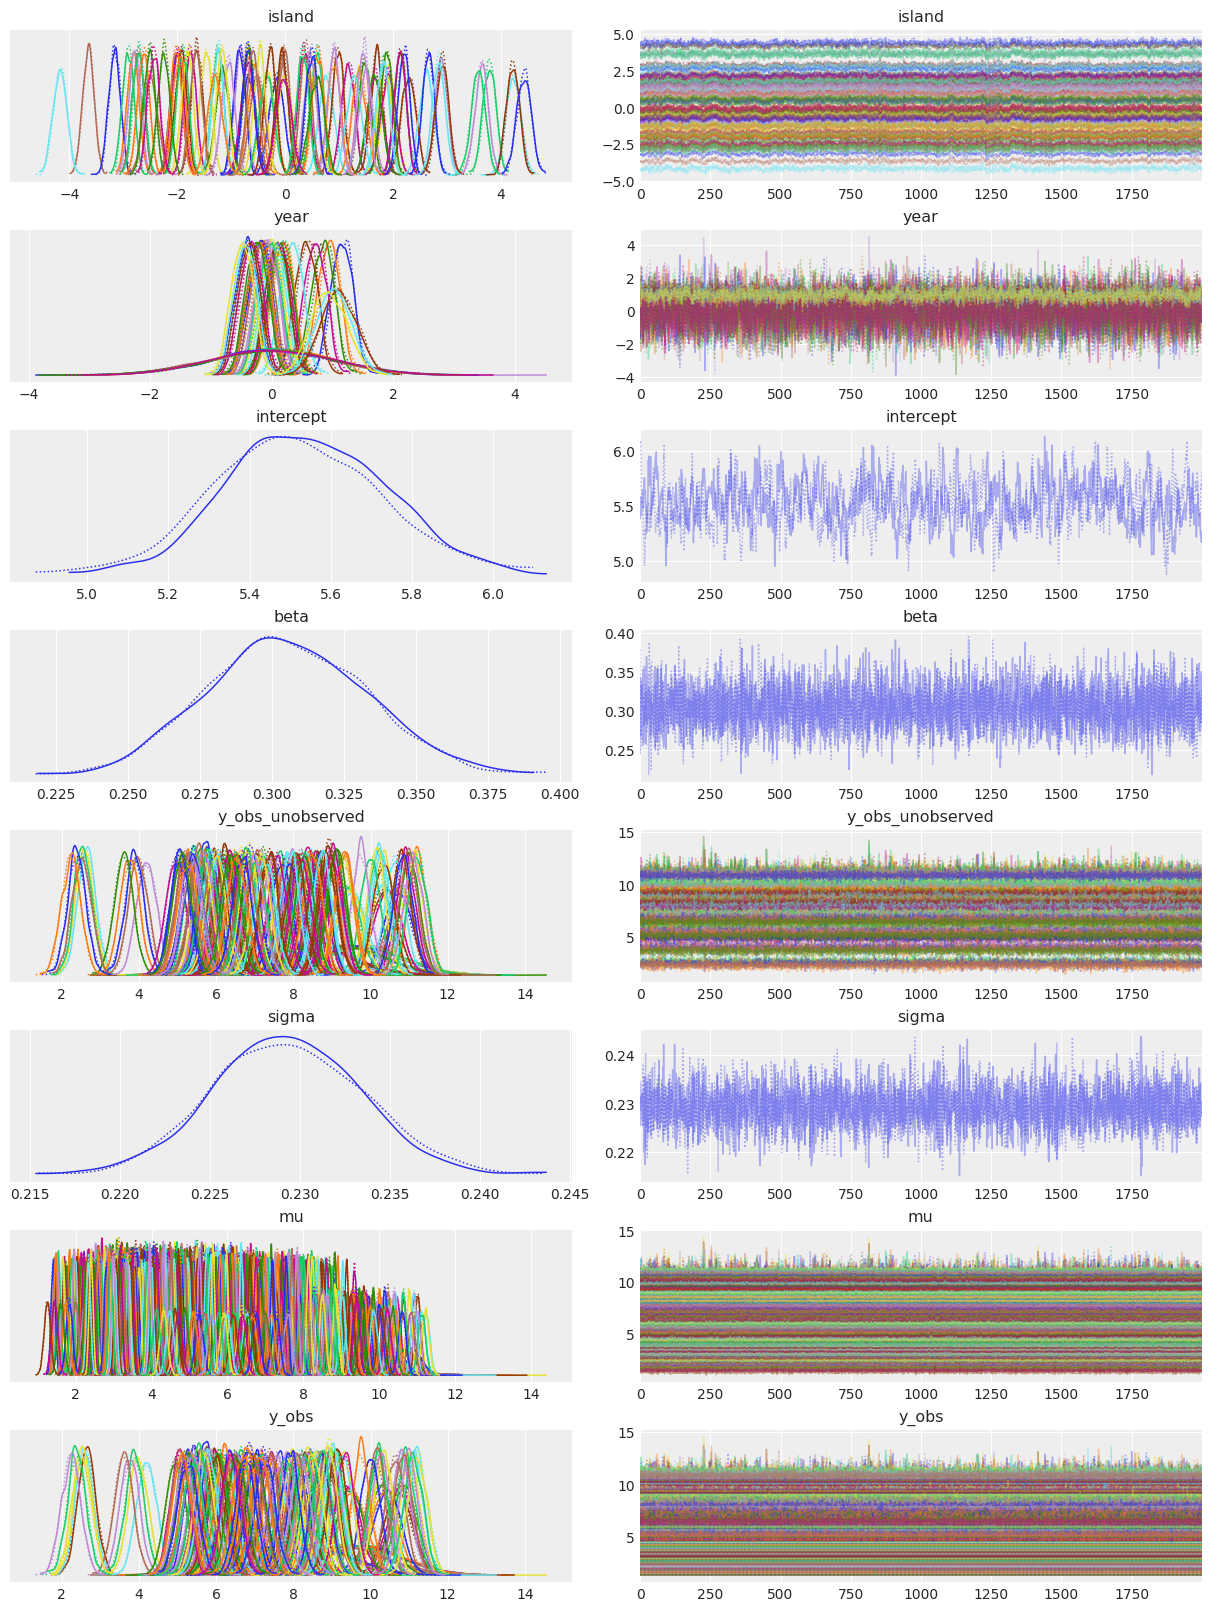

In [12]:
az.plot_trace(trace_twfe);

In [16]:
posterior_samples = trace_twfe.posterior

delta_samples = posterior_samples['delta']

# 0以上のサンプルの割合を計算
prob_delta_positive = np.mean(delta_samples > 0)

print(f"Pr(intercept > 0) = {prob_delta_positive:.4f}")

Pr(intercept > 0) = 1.0000


In [13]:
with twfe:
    pm.compute_log_likelihood(trace_twfe)

Output()

In [14]:
az.waic(trace_twfe)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    20.28    58.76
p_waic      132.36        -

There has been a warning during the calculation. Please check the results.

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


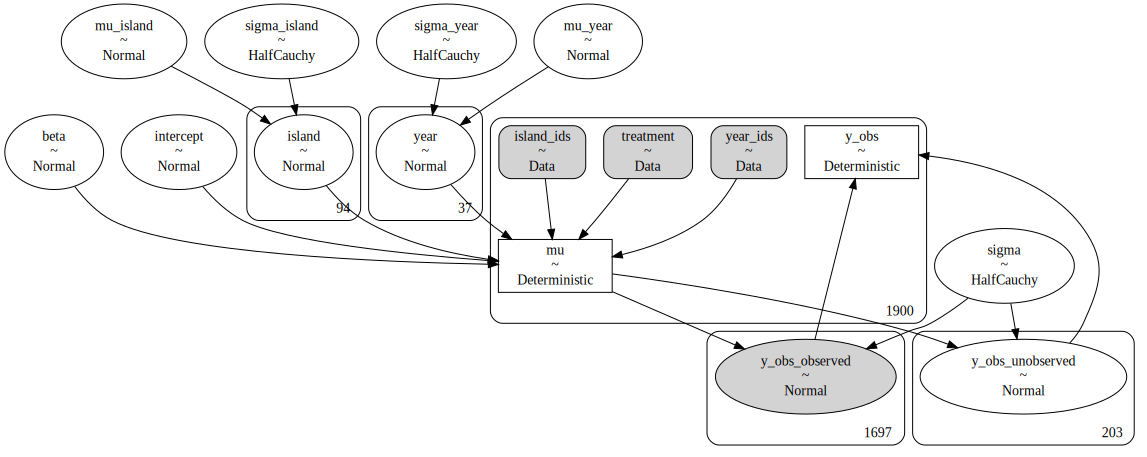

In [9]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])


with pm.Model() as twfe_h:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'])
    year_ids = pm.Data('year_ids', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=100)
    sigma_island = pm.HalfCauchy('sigma_island', beta=100)
    mu_year = pm.Normal('mu_year', mu=0, sigma=100)
    sigma_year = pm.HalfCauchy('sigma_year', beta=100)
    island = pm.Normal('island', mu=mu_island, sigma=sigma_island, shape=len(df['island_ids'].unique()))
    year = pm.Normal('year', mu=mu_year, sigma=sigma_year, shape=len(df['years'].unique()))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100)
    sigma = pm.HalfCauchy('sigma', beta=100)

    # expectation
    mu = pm.Deterministic('mu', intercept + beta * treatment + island[island_ids] + year[year_ids])

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(twfe_h)

In [18]:
with twfe_h:
    trace_twfe_h = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [19]:
az.summary(trace_twfe_h, hdi_prob=.95, var_names=['delta', 'sigma'])

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
delta    44.003  80.434  -107.099    208.464      1.167    1.071    4739.0   
sigma  1034.103  18.643   995.908   1069.764      0.347    0.246    2864.0   

       ess_tail  r_hat  
delta    3398.0    1.0  
sigma    2524.0    1.0

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


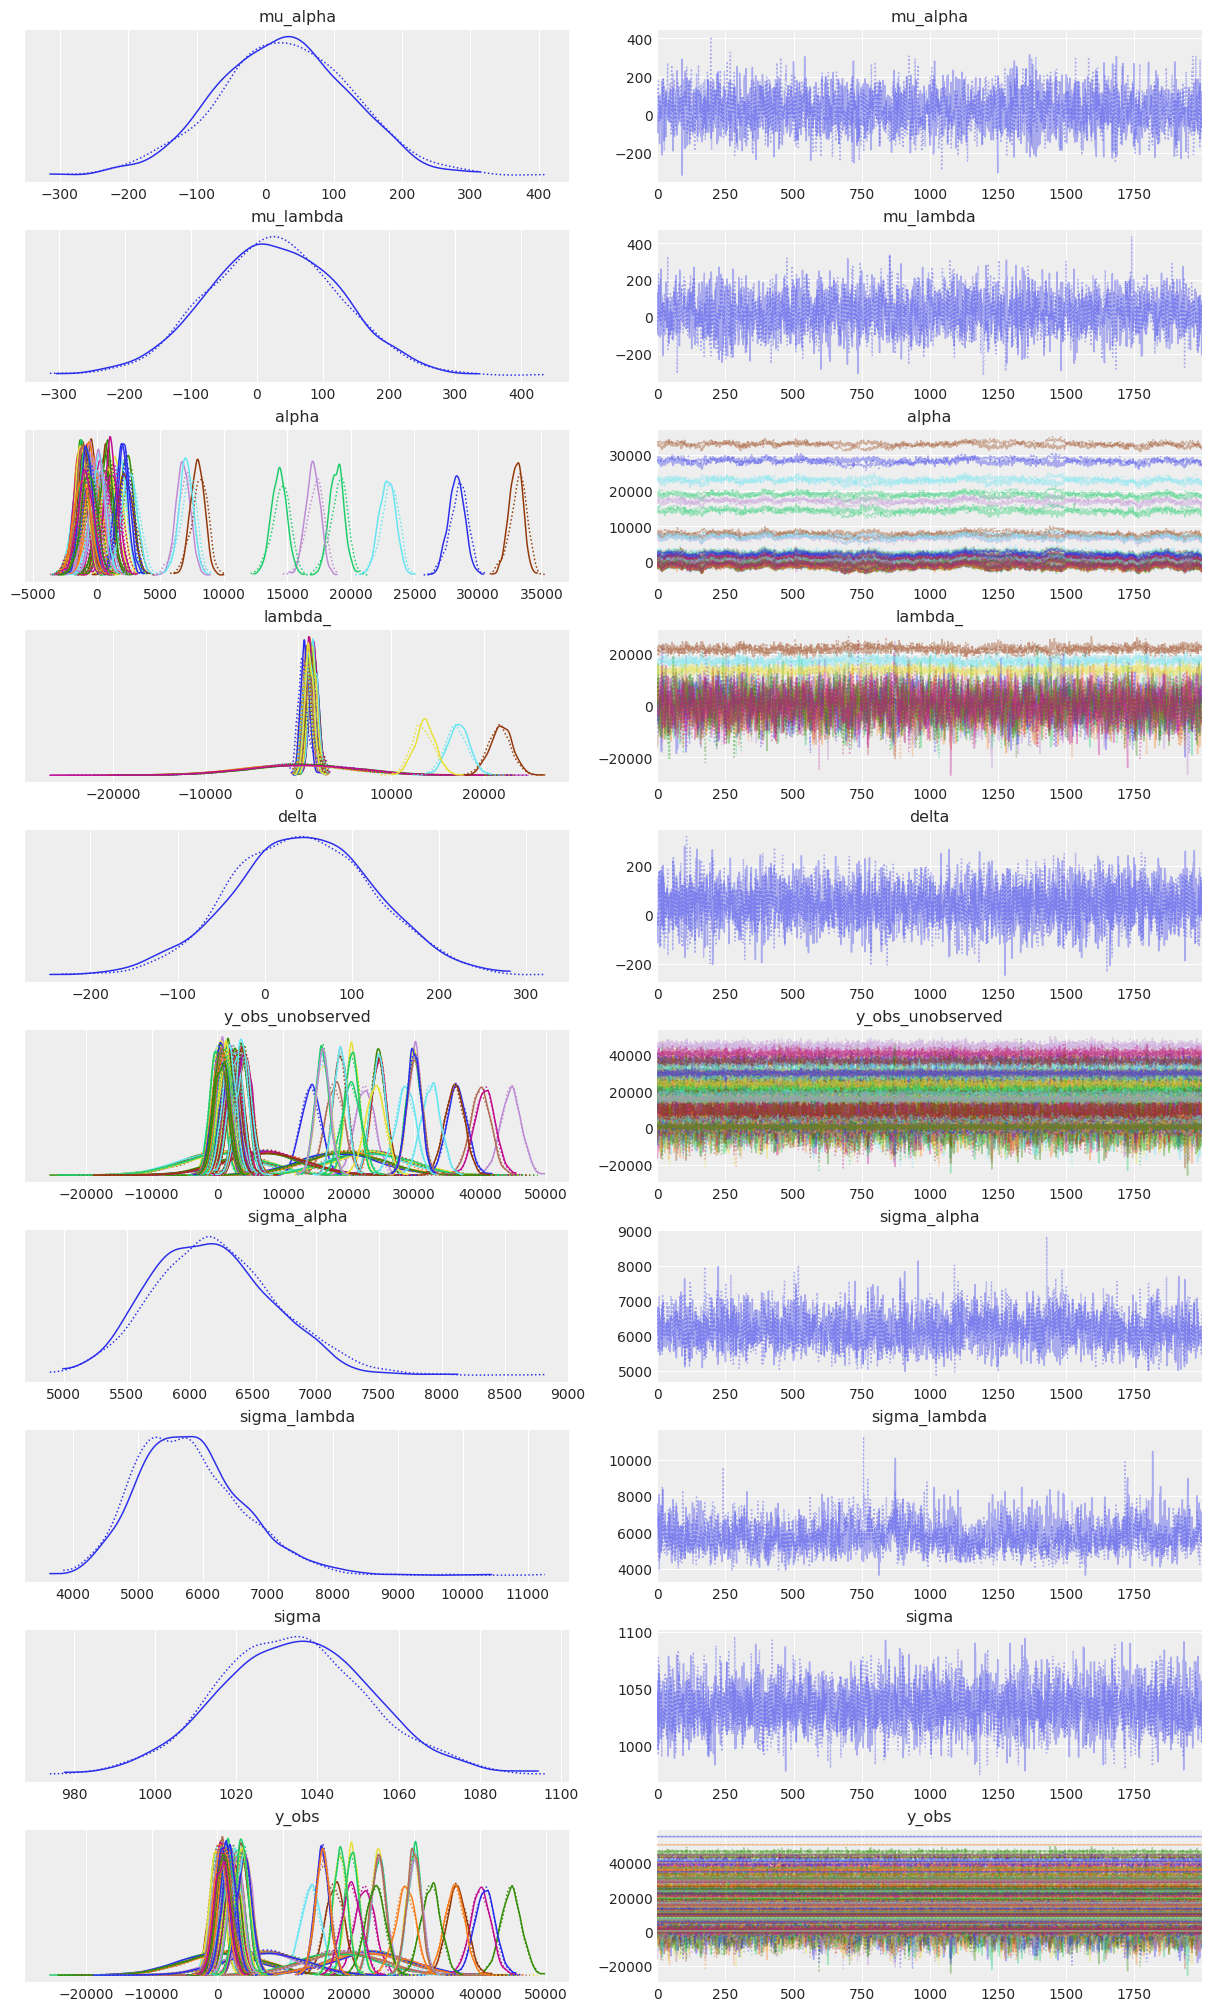

In [20]:
az.plot_trace(trace_twfe_h);

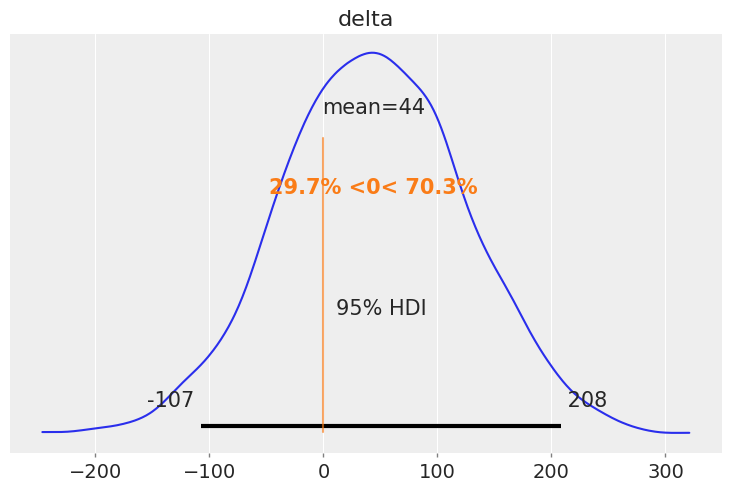

In [41]:
az.plot_posterior(trace_twfe_h, var_names=['delta'], ref_val=0, hdi_prob=.95);

In [24]:
posterior_samples = trace_twfe_h.posterior

delta_samples = posterior_samples['delta']

# 0以上のサンプルの割合を計算
prob_delta_positive = np.mean(delta_samples > 0)

print(f"Pr(intercept > 0) = {prob_delta_positive:.4f}")

Pr(intercept > 0) = 0.7030


In [22]:
with twfe_h:
    pm.compute_log_likelihood(trace_twfe_h)

Output()

In [6]:
az.waic(trace_twfe_h)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -14313.66   162.60
p_waic      219.02        -

There has been a warning during the calculation. Please check the results.

## Studet't分布

自由度パラメータ: $\nu = 3$

### ベイズモデル

##### モデルの定義

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


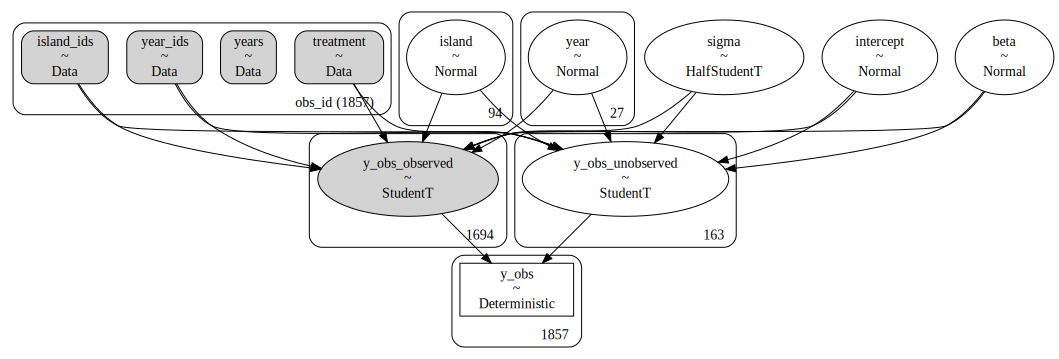

In [13]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
year_ids, unique_year_ids = pd.factorize(df['year'])

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as twfe_student_t:
    # data
    island_ids = pm.Data('island_ids', island_ids, dims='obs_id')
    year_ids = pm.Data('year_ids', year_ids, dims='obs_id')
    years = pm.Data('years', df['year'], dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    island = pm.Normal('island', mu=0, sigma=1, shape=len(unique_island_ids))
    year = pm.Normal('year', mu=0, sigma=1, shape=len(unique_year_ids))

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + beta * treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(twfe_student_t)

##### サンプリング

In [ ]:
with twfe_student_t:
    initvals = {'intercept': 5, 'beta': 0, 'sigma': 0}
    trace_twfe_student_t = pm.sample(
        draws=1000,
        tune=100,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals,
    )

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


##### 結果の確認

In [15]:
az.summary(trace_twfe_student_t, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  5.721  0.222     5.285      6.162      0.022    0.016     105.0   
beta       0.165  0.021     0.125      0.206      0.000    0.000    1950.0   
sigma      0.116  0.003     0.109      0.121      0.000    0.000    1513.0   

           ess_tail  r_hat  
intercept     229.0    1.0  
beta         1481.0    1.0  
sigma        1306.0    1.0

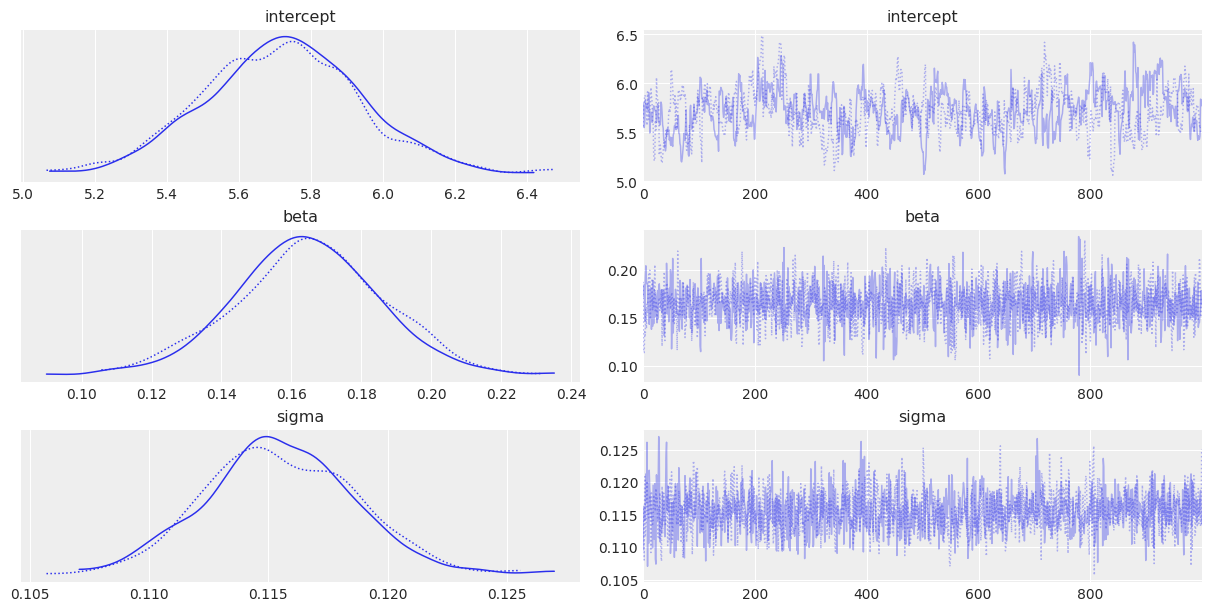

In [16]:
az.plot_trace(trace_twfe_student_t, var_names=['intercept', 'beta', 'sigma']);

In [17]:
with twfe_student_t:
    pm.compute_log_likelihood(trace_twfe_student_t)

Output()

In [18]:
az.waic(trace_twfe_student_t)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   418.30    55.88
p_waic      169.96        -

There has been a warning during the calculation. Please check the results.

### 階層ベイズモデル

#### タイムトレンドなし

##### モデルの定義

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


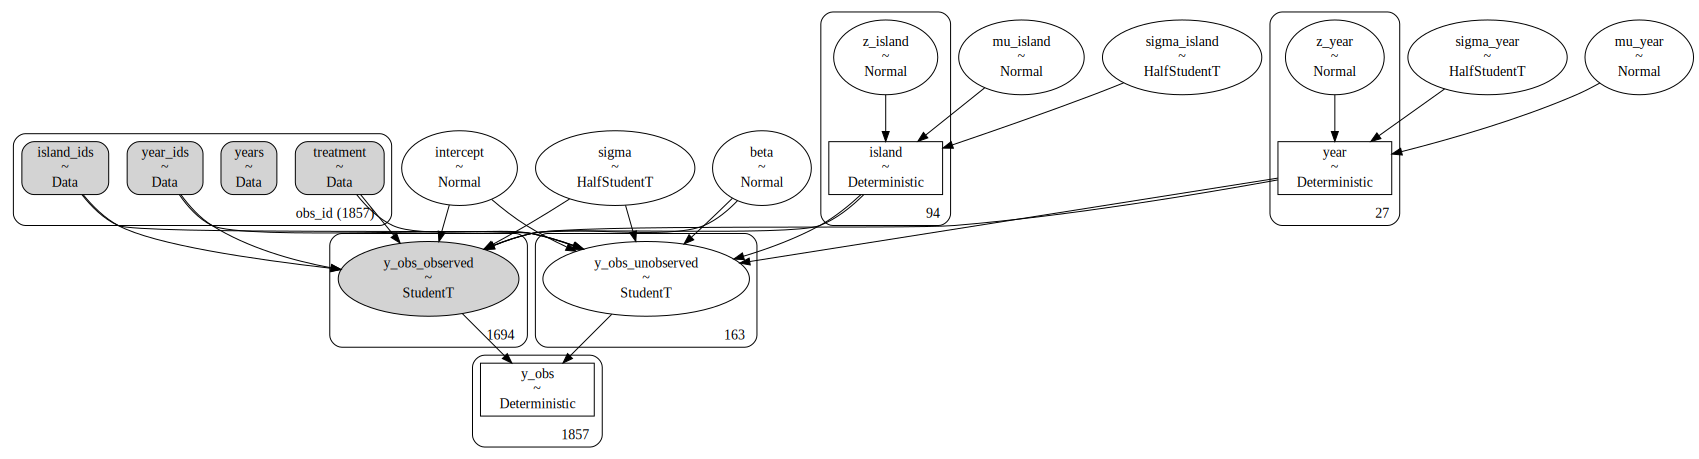

In [21]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_islandds = pd.factorize(df['island_ids'])
df['year_ids'], unique_year_ids = pd.factorize(df['year'])

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as twfe_h_student_t:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'], dims='obs_id')
    year_ids = pm.Data('year_ids', df['year_ids'], dims='obs_id')
    years = pm.Data('years', df['year'], dims='obs_id')
    treatment = pm.Data('treatment', df['after_treatment'], dims='obs_id')

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=1)
    sigma_island = pm.HalfStudentT('sigma_island', nu=3, sigma=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, shape=len(unique_islandds))
    island = pm.Deterministic('island', mu_island + sigma_island * z_island)

    mu_year = pm.Normal('mu_year', mu=0, sigma=1)
    sigma_year = pm.HalfStudentT('sigma_year', nu=3, sigma=1)
    z_year = pm.Normal('z_year', mu=0, sigma=1, shape=len(unique_year_ids))
    year = pm.Deterministic('year', mu_year + sigma_year * z_year)

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=1)

    # expectation
    mu = intercept + beta * treatment + island[island_ids] + year[year_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['log_pop'])

pm.model_to_graphviz(twfe_h_student_t)

##### サンプリング

In [ ]:
with twfe_h_student_t:
    initvals = {'intercept': 2, 'beta': 0.1, 'sigma': 0.1}
    trace_twfe_h_student_t = pm.sample(
        draws=1000,
        tune=100,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
        initvals=initvals,
    )

  0%|          | 0/1100 [00:00<?, ?it/s]

  0%|          | 0/1100 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


##### 結果の確認

In [23]:
az.summary(trace_twfe_h_student_t, hdi_prob=.95, var_names=['intercept', 'beta', 'sigma'])

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept  1.742  0.774     0.097      3.075      0.041    0.029     365.0   
beta       0.147  0.020     0.105      0.184      0.001    0.001     392.0   
sigma      0.115  0.003     0.109      0.121      0.000    0.000    1444.0   

           ess_tail  r_hat  
intercept     684.0   1.01  
beta          643.0   1.00  
sigma        1416.0   1.00

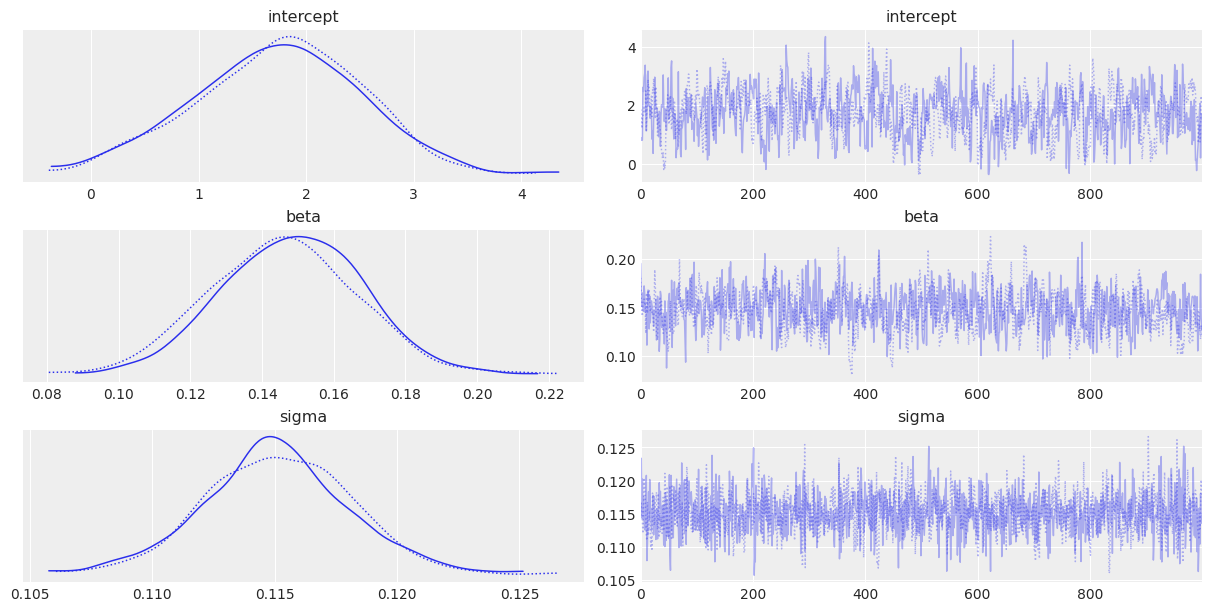

In [27]:
az.plot_trace(trace_twfe_h_student_t, var_names=['intercept', 'beta', 'sigma']);

In [28]:
with twfe_h_student_t:
    pm.compute_log_likelihood(trace_twfe_h_student_t)

Output()

In [29]:
az.waic(trace_twfe_h_student_t)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1694 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   429.05    55.83
p_waic      157.75        -

There has been a warning during the calculation. Please check the results.

## サンプリングの保存

In [30]:
# az.to_netcdf(trace_twfe, './sample/traces_twfe_log.nc')
# az.to_netcdf(trace_twfe_h, './sample/traces_twfe_h_log.nc')
az.to_netcdf(trace_twfe_student_t, './sample/traces_twfe_student_t_log.nc')
az.to_netcdf(trace_twfe_h_student_t, './sample/traces_twfe_h_student_t_log.nc')

'./sample/traces_twfe_h_student_t_log.nc'

## サンプリングのインポート

In [ ]:
trace_twfe = az.from_netcdf('./sample/traces_twfe_log.nc')
trace_twfe_h = az.from_netcdf('./sample/traces_twfe_h_log.nc')
trace_twfe_student_t = az.from_netcdf('./sample/traces_twfe_student_t_log.nc')
trace_twfe_h_student_t = az.from_netcdf('./sample/traces_twfe_h_student_t_log.nc')